# Visualisation of the clusters

## Loading the data and some preprocessing

In [2]:
import geopandas as gpd
import pandas as pd
#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#import clusters
granularity = 7
dict_clusters = {}
for year in range(2018, 2019):
    dict_clusters[year] = pd.read_parquet(f'../data/results/cluster_{year}/clusters_{year}_g{granularity}_v0.2.parquet')


import os
import pandas as pd
dict_results = {}
from tqdm import tqdm 
for year in tqdm(range(2018, 2019)):
    cols = ['geometry', 'tree_type', 'essence']
    results = tcl[cols].merge(dict_clusters[year], left_index=True, right_on='index_reference', how='right')
    results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:2154')
    results['centroid'] = results.geometry.centroid
    #set geometry to centroid
    results = results.set_geometry('centroid')
    dict_results[year] = results

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


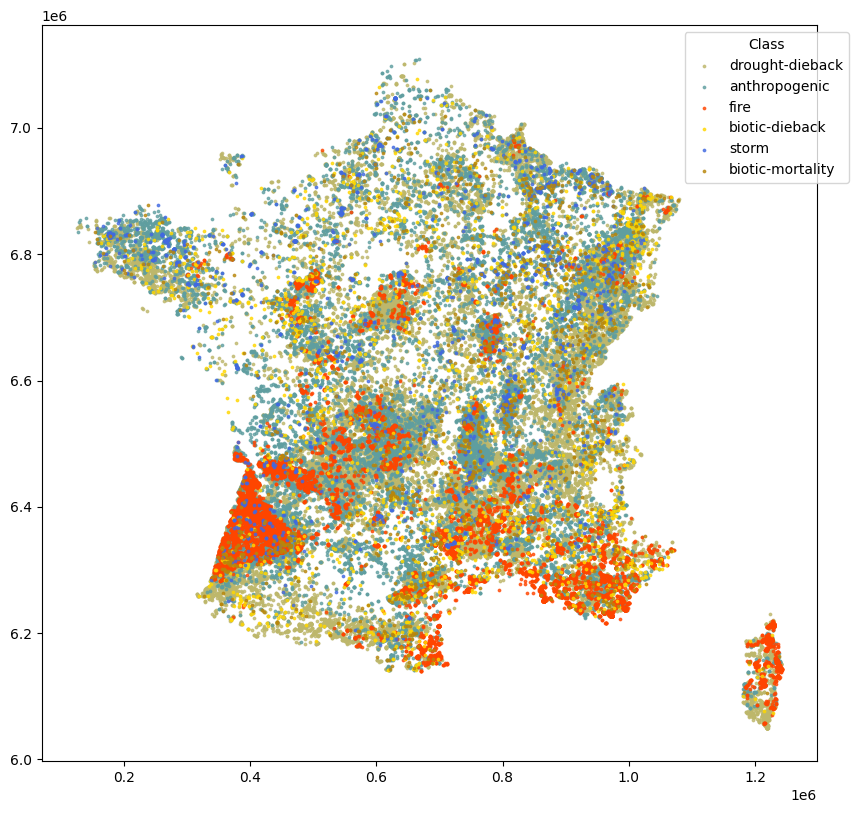

In [3]:
import matplotlib.pyplot as plt

r = dict_results[2018]
r = r[ r.index == 0]
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

# Count the points in each class
class_counts = r['Class'].value_counts().sort_values()

# Assign a zorder based on the count - lower count gets higher zorder
zorders = {class_name: i for i, class_name in enumerate(class_counts.index[::-1], start=1)}



fig, ax = plt.subplots(figsize=(10,10))

# Loop through the sorted classes and plot each one with the corresponding zorder
for class_name, zorder in zorders.items():
    gdf_class = r[r['Class'] == class_name]
    gdf_class.plot(ax=ax, label=class_name, zorder=zorder, color=custom_color_mapping[class_name], markersize=3, alpha=.75)

ax.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper right')

In [3]:
#define a function that takes a small group
#compute the median of [Start_date, End_date] for each row 
#return the list [(class, median, similarity, essence, tree_type)]) for each row] but sorted by median 
def get_history(group : gpd.GeoDataFrame) -> list:
    group['median'] = group[['Start_Date', 'End_Date']].median(axis=1)
    group = group.sort_values(by='median', ascending=True)

    # Step 3 and 4: Create chains and calculate time between disturbances
    # Initialize an empty list to store the chains
    chains = []
    times_between = []

    # Loop through the sorted DataFrame
    for i in range(len(group) - 1):
        current_class = group.iloc[i]['Class']
        next_class = group.iloc[i + 1]['Class']
        chain = f'{current_class} -> {next_class}'
        chains.append(chain)
        
        # Calculate the time difference between the current end date and the next start date
        time_diff = (group.iloc[i + 1]['median'] - group.iloc[i]['median']).days / 365
        times_between.append(time_diff)

    # Create the new DataFrame
    chains_df = pd.DataFrame({
        'Chain': chains,
        'Time_Between_Disturbances': times_between
    })

    chains_df['Essence'] = group['essence'].iloc[0]
    chains_df['Tree_Type'] = group['tree_type'].iloc[0]
    chains_df['Centroid'] = group['centroid'].iloc[0]

    return chains_df

In [4]:
get_history(groups[2])

NameError: name 'groups' is not defined

In [73]:
groups = r.groupby('index_reference')
groups = [group for _, group in groups if len(group) > 1]

from tqdm import tqdm
histories = []
for group in tqdm(groups):
    histories.append(get_history(group))

histories = pd.concat(histories)
histories = gpd.GeoDataFrame(histories, geometry='Centroid', crs='EPSG:2154')

histories[['start', 'end']] = histories['Chain'].str.split(' -> ', expand=True)
histories = histories[ ~(histories['end'] == 'storm') ]
histories = histories[ ~(histories['start'] == histories['end']) ]

#get the five more frequent chains
histories = histories[histories['Chain'].isin(histories['Chain'].value_counts().head(5).index)]
histories.value_counts('Chain')

In [82]:
histories[['Chain', 'Time_Between_Disturbances', 'Centroid']].to_csv('data_disturbances.csv')

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

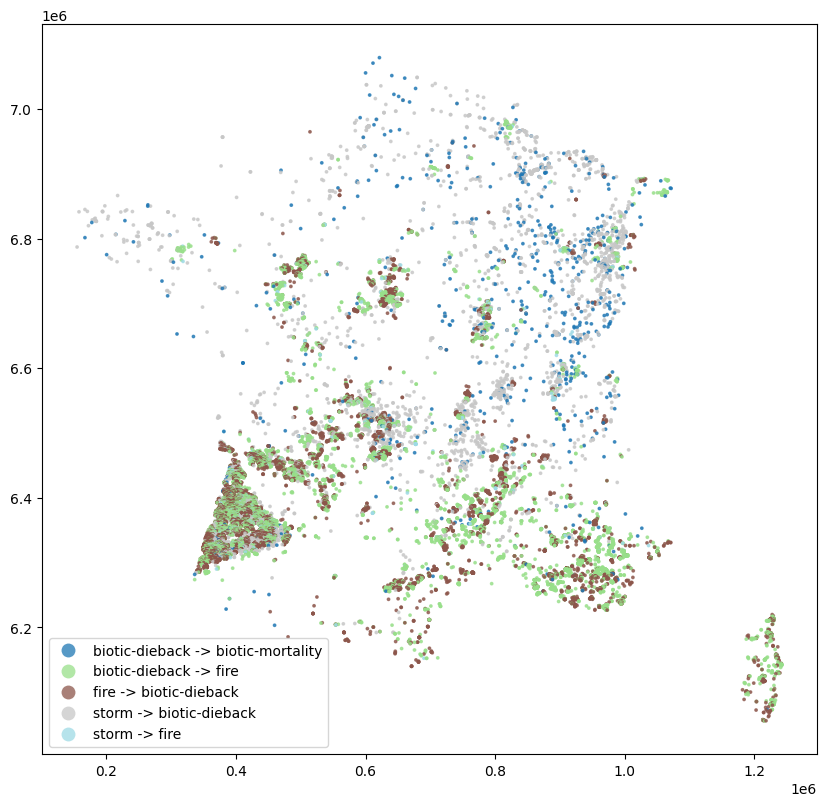

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
histories.plot(ax=ax, column='Chain', legend=True, cmap='tab20', markersize=3, alpha=.75)

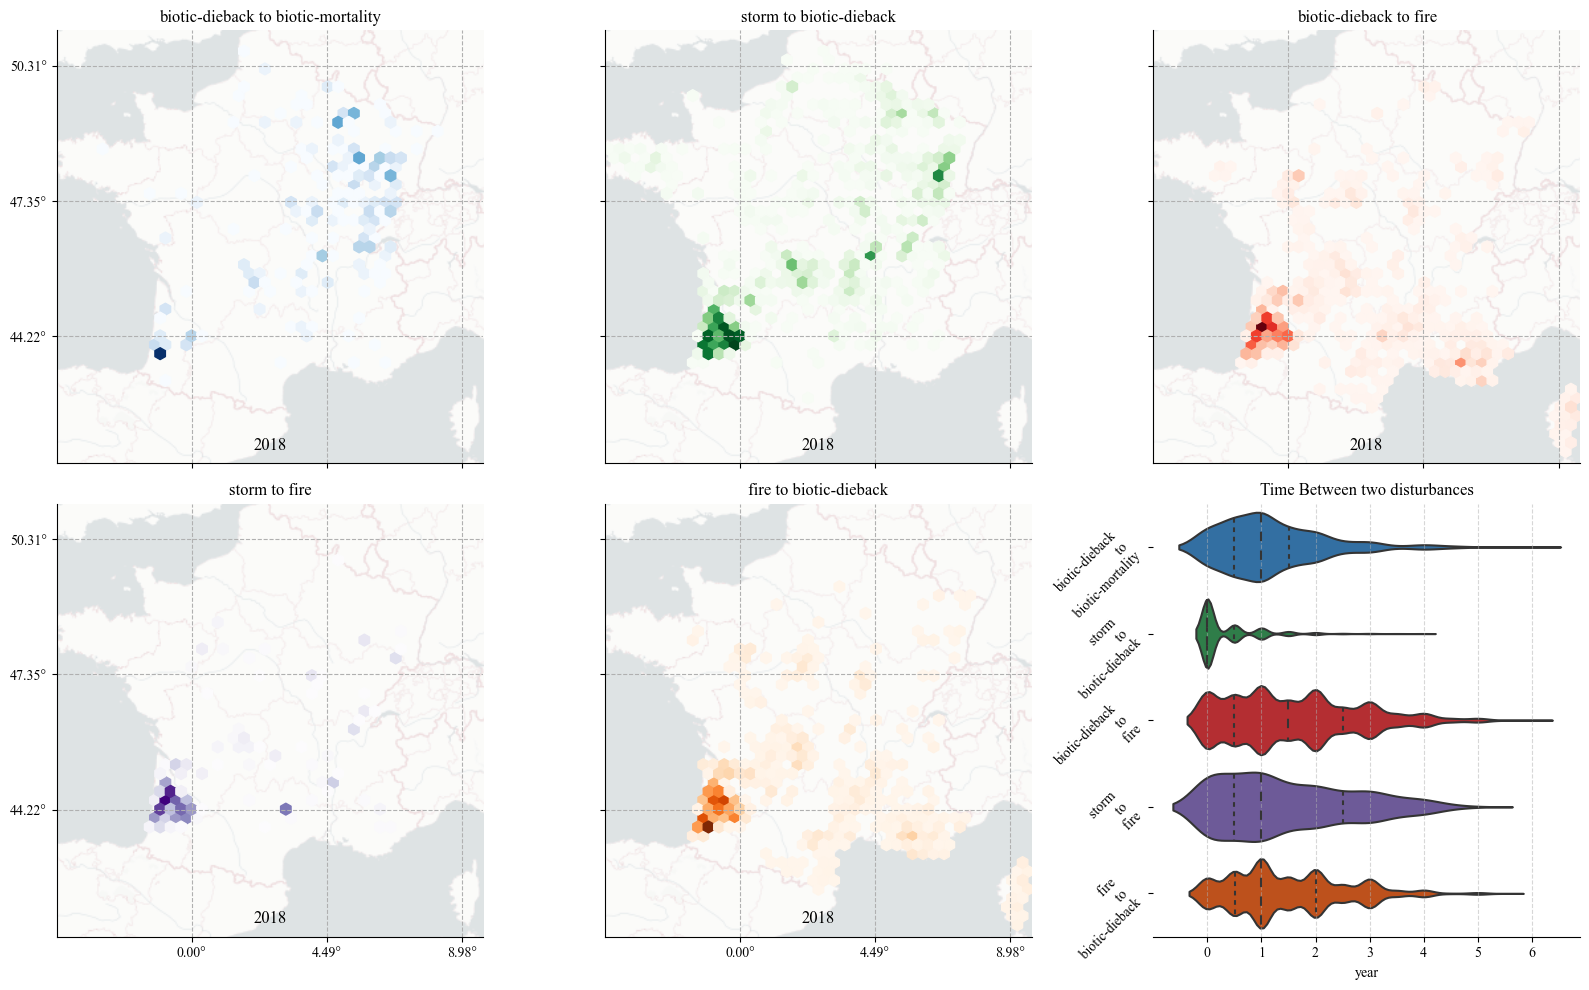

In [155]:
# Re-importing the necessary libraries
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FuncFormatter
import seaborn as sns
import numpy as np
import math

# Re-define the web_mercator_to_lat_lon function
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)

# Reload the data
gdf = histories.to_crs(epsg=3857)
minx, miny, maxx, maxy = gdf.geometry.buffer(1000).total_bounds

# Get the first 5 unique chains for plotting
unique_chains = gdf['Chain'].unique()[:5]

# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Create figure and GridSpec
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig)

# Define individual colormaps for each chain
chain_colormaps = [plt.cm.Blues, plt.cm.Greens, plt.cm.Reds, plt.cm.Purples, plt.cm.Oranges]

# Create a subplot for each of the first 5 chains
for idx, chain in enumerate(unique_chains):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    
    # Select the data for the current chain
    gdf_chain = gdf[gdf['Chain'] == chain]
    
    # Plot hexbin for the chain with the specific colormap
    hb = ax.hexbin(gdf_chain.geometry.x, gdf_chain.geometry.y, \
                   gridsize=40, cmap=chain_colormaps[idx], mincnt=2, \
                    extent = (minx, maxx, miny, maxy))
    
    # Normalize the counts to range [0, 1] and then apply a square root to smooth the colors
    # and set alpha starting from 0 to 1
    counts = hb.get_array()
    max_count = counts.max()
    if max_count > 0:
        scaled_counts = np.sqrt(counts / max_count)
        colors = chain_colormaps[idx](scaled_counts)
        colors[:, 3] = scaled_counts  # Adjust alpha based on count
        hb.set_facecolors(colors)

    # Adding basemap with contextily
    cx.add_basemap(ax, crs=gdf.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, alpha=0.75, zoom=5)

    ax.set_title(chain.replace('->', 'to'))
    ax.axis('equal')
    ax.grid(True, linestyle='--')  # Add grid

    # Using MultipleLocator to set tick locations
    ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
    ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

    # Using FuncFormatter to convert tick labels to lat/lon
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
    ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
    
    ax.annotate(year, xy=(0.5, 0), xytext=(0, 10),
            xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # # Setting the same extents for all plots
    ax.set_xlim((minx, maxx))
    ax.set_ylim((miny, maxy))

# Prepare the data for the violin plot
time_between_data = [gdf[gdf['Chain'] == chain]['Time_Between_Disturbances'].values for chain in unique_chains]

# Create a violin plot in the last subplot space
ax_violin = fig.add_subplot(gs[1, 2])
parts = sns.violinplot(data=time_between_data, ax=ax_violin, orient='h', palette=[colormap(0.75) for colormap in chain_colormaps], \
                        inner='quartile', density_norm='width', scale='width')
ax_violin.set_title('Time Between two disturbances')
#set y labels with 45 degrees rotation
ax_violin.set_yticklabels([u.replace('->', '\n to \n') for u in unique_chains], rotation=45)
ax_violin.set_xlabel('year')

#remove all spines of ax_violin 
ax_violin.spines['right'].set_visible(False)
ax_violin.spines['top'].set_visible(False)
ax_violin.spines['left'].set_visible(False)
# ax_violin.spines['bottom'].set_visible(False)

#add vertical grid
ax_violin.grid(axis='x', linestyle='--', alpha=0.5)

# # Match the colors of the violin plot parts with the hexbin plots
# for pc, colormap in zip(parts.collections[::2], chain_colormaps):  # every second part is the body of the violin
#     pc.set_facecolor(colormap(0.75))
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.75)

# Hide x and y tick labels for non-edge subplots for a cleaner look
for i, ax in enumerate(fig.axes[:-1]):  # Exclude the violin plot
    if i % 3 != 0:
        ax.set_yticklabels([])
    if i < 3:
        ax.set_xticklabels([])

plt.tight_layout()
plt.show()


In [156]:
fig.savefig(f'../figures/cluster_consecutive_disturbance_{year}.png', dpi=300, bbox_inches='tight')

# Main Attribution

In [ ]:
#TODO Change Biotic-Mortality to Mortatity


In [4]:
#save extents the figure : 

r = dict_results[2018]
epsg = 3857
gdf_web_mercator = r.to_crs(epsg=epsg)

#set df_lim (GeoDataFrame as the bounds of the results)
minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(1000).total_bounds

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


0 0
0 1
0 2
1 0
1 1
1 2


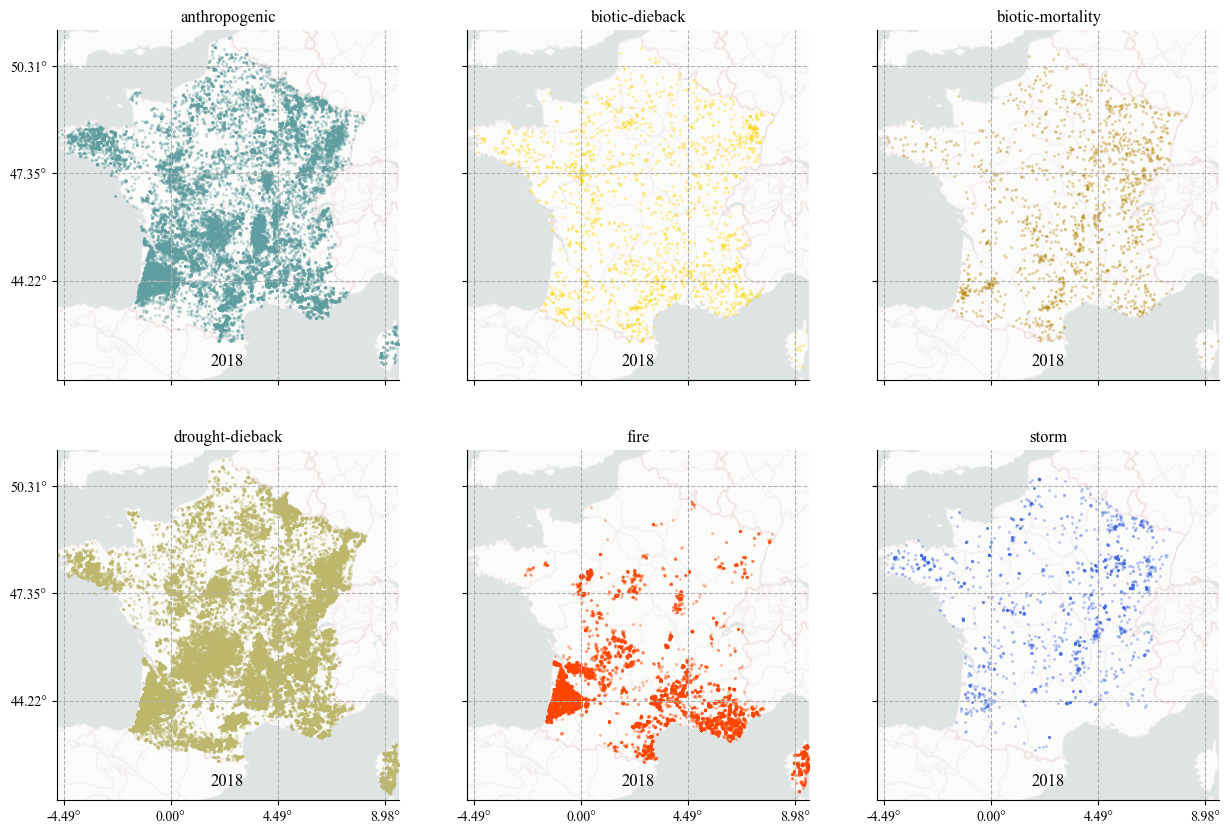

In [5]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FuncFormatter
import contextily as cx 
import math
from utils import pol_from_points

#change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Define a function to convert Web Mercator to lat/lon
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)

class_names = custom_color_mapping.keys()
for year in range(2018, 2019):
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)

    
    r = dict_results[year]
    #selection of the main disturbances 
    r = r[ r.index == 0]
    gdf_web_mercator = r.to_crs(epsg=epsg)

    #set df_lim (GeoDataFrame as the bounds of the results)
    # minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(1000).total_bounds

    axes = []
    for idx, class_name in enumerate(sorted(class_names)):
        row = idx // 3 
        col = idx % 3
        print(row, col)

        #get gdf and simplify 
        gdf = gdf_web_mercator[ (gdf_web_mercator['Class'] == class_name) ]

        ax = fig.add_subplot(gs[row, col])
        
        axes.append(ax)

        # df_lim.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
        gdf[gdf['Class'] == class_name].plot(ax=ax, color=custom_color_mapping[class_name], alpha=0.25, markersize=1.6)

        # Adding basemap with contextily
        cx.add_basemap(ax, crs=gdf_web_mercator.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, alpha=0.75, zoom=5)

        ax.set_title(class_name)
        ax.axis('equal')
        ax.grid(True, linestyle='--')  # Add grid


        # Using MultipleLocator to set tick locations
        ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

        # Using FuncFormatter to convert tick labels to lat/lon
        ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
        ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
        
        ax.annotate(year, xy=(0.5, 0), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # # Setting the same extents for all plots
        ax.set_xlim((minx, maxx))
        ax.set_ylim((miny, maxy))

    for i,ax in enumerate(axes):
        if i < 3:
            ax.set_xticklabels([])
        if i % 3 != 0:
            ax.set_yticklabels([])

    fig.savefig(f'../figures/cluster_{year}_g{granularity}_v0.2.png', dpi=300, bbox_inches='tight', transparent=True)

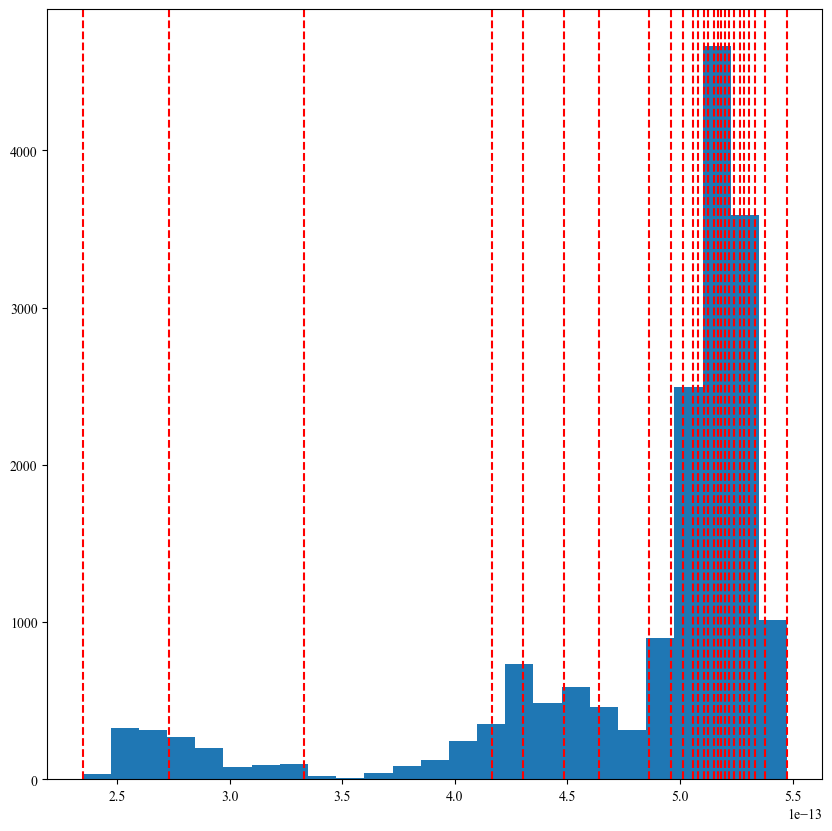

In [53]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
def calculate_local_densities(gdf, bandwidth=1.0):
    coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
    kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel='gaussian', algorithm='ball_tree')
    kde.fit(coords)
    densities = np.exp(kde.score_samples(coords))  # use exponential to convert log density to density
    return densities
num_levels = 25
densities = calculate_local_densities(r[ r['Class'] == 'fire'] , bandwidth=500000)
# Define bins using quantiles
quantile_bins = np.linspace(0, 1, num_levels + 1)
quantile_values = np.quantile(densities, quantile_bins)

# Categorize densities into levels using pd.cut and quantiles
density_levels = pd.cut(densities, bins=quantile_values, labels=False, include_lowest=True)

fig, ax = plt.subplots(figsize=(10,10))
a = ax.hist(densities, bins=25)
for q in quantile_values:
    ax.axvline(q, color='red', linestyle='--')


In [64]:
def calculate_marker_size(ax, desired_radius_meters):
    # Get the current axis limits
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()

    # Calculate the number of meters per pixel
    # Assuming the aspect ratio is 1:1
    plot_width_meters = max(x1 - x0, y1 - y0)
    plot_width_pixels = ax.get_window_extent().width
    meters_per_pixel = plot_width_meters / plot_width_pixels

    # Convert the desired radius from meters to pixels
    radius_pixels = desired_radius_meters / meters_per_pixel

    # Marker size in points² (1 point = 1/72 inch)
    # Matplotlib sizes markers in area, not radius, so square and multiply by pi
    dpi = 300
    radius_points = radius_pixels * (72 / dpi)
    marker_size_points_squared = (2 * radius_points)**2 * np.pi

    return marker_size_points_squared

# Use this function to calculate the marker size
marker_size = calculate_marker_size(ax, 7000)


In [65]:
marker_size

1.5933222600924866

0 0
0 1
0 2
1 0
1 1
1 2


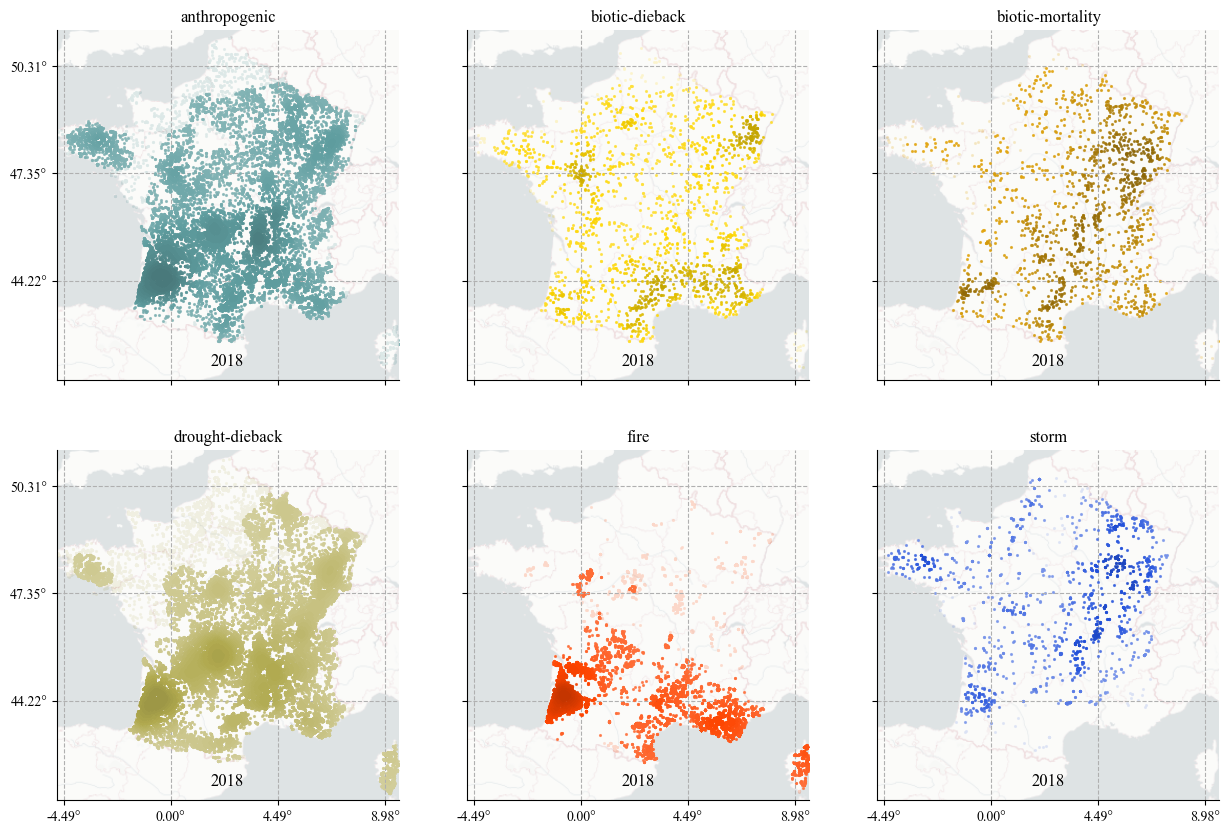

In [6]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FuncFormatter
import contextily as cx 
import math
from utils import pol_from_points

custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

#change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

from sklearn.neighbors import KernelDensity
import numpy as np

# Function to calculate local densities using KDE
def calculate_local_densities(gdf, bandwidth=50000.0):
    coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
    kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel='exponential', algorithm='ball_tree')
    kde.fit(coords)
    densities = np.exp(kde.score_samples(coords))  # use exponential to convert log density to density
    return densities

import colorsys
import matplotlib

def adjust_color(color, factor):
    # Convert hex to RGB
    r, g, b = color
    
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Modify Lightness/Saturation
    l = max(min(l * factor, 1.0), 0.0)
    
    # Convert HLS back to RGB
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return '#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))


# Define a function to convert Web Mercator to lat/lon
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)

class_names = custom_color_mapping.keys()
bandwith = 50000
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

num_levels = 25  # Number of density levels

for year in range(2018, 2019):
    r = dict_results[year]
    #selection of the main disturbances 
    r = r[ r.index == 0]
    gdf_web_mercator = r.to_crs(epsg=epsg)

    #set df_lim (GeoDataFrame as the bounds of the results)
    # minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(1000).total_bounds

    axes = []
    for idx, class_name in enumerate(sorted(class_names)):
        row = idx // 3 
        col = idx % 3
        print(row, col)

        #get gdf and simplify 
        gdf = gdf_web_mercator[ (gdf_web_mercator['Class'] == class_name) ]
        gdf_class = gdf[gdf['Class'] == class_name]
        # Calculate local densities
        densities = calculate_local_densities(gdf_class, bandwith)

        # Define bins using quantiles
        quantile_bins = np.linspace(0, 1, num_levels + 1)
        quantile_values = np.quantile(densities, quantile_bins)

        # Categorize densities into levels using pd.cut and quantiles
        density_levels = pd.cut(densities, bins=quantile_values, labels=False, include_lowest=True)

        # Add density levels to your GeoDataFrame
        gdf_class['density_level'] = density_levels
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

        #modify color
        base_color = custom_color_mapping[class_name]
        #convert matplotlib color name to rgb 
        base_color = matplotlib.colors.to_rgb(base_color)

        for level in range(num_levels):
            gdf_level = gdf_class[gdf_class['density_level'] == level]
            adjusted_color = adjust_color(base_color, 1.25 - (level / num_levels) * 0.5) # Adjust factor as needed
            gdf_level.plot(ax=ax, color=adjusted_color, alpha=0.75, zorder=level, markersize=1.6)
        
        # Adding basemap with contextily
        cx.add_basemap(ax, crs=gdf_web_mercator.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, alpha=0.75, zoom=5)

        ax.set_title(class_name)
        ax.axis('equal')
        ax.grid(True, linestyle='--')  # Add grid


        # Using MultipleLocator to set tick locations
        ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

        # Using FuncFormatter to convert tick labels to lat/lon
        ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
        ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
        
        ax.annotate(year, xy=(0.5, 0), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # # Setting the same extents for all plots
        ax.set_xlim((minx, maxx))
        ax.set_ylim((miny, maxy))

    for i,ax in enumerate(axes):
        if i < 3:
            ax.set_xticklabels([])
        if i % 3 != 0:
            ax.set_yticklabels([])

    fig.savefig(f'../figures/density_cluster_{year}_g{granularity}_b{bandwith}_v0.2.png', dpi=300, bbox_inches='tight', transparent=False)


In [15]:
from PIL import Image
import os

# Directory containing PNG files
images = []
for year in range(2015, 2021):
    directory = f'../figures/density_cluster_{year}_g{granularity}_b{bandwith}_v0.1.png'
    img = Image.open(directory)
    img = img.resize((img.width // 2, img.height // 2))
    img = img.quantize(method=Image.FASTOCTREE)
    images.append(img)

# Create the GIF
gif_path = f"../figures/density_cluster_g{granularity}_b{bandwith}_v0.1.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=True, duration=1000, loop=0)


MovieWriter ffmpeg unavailable; using Pillow instead.


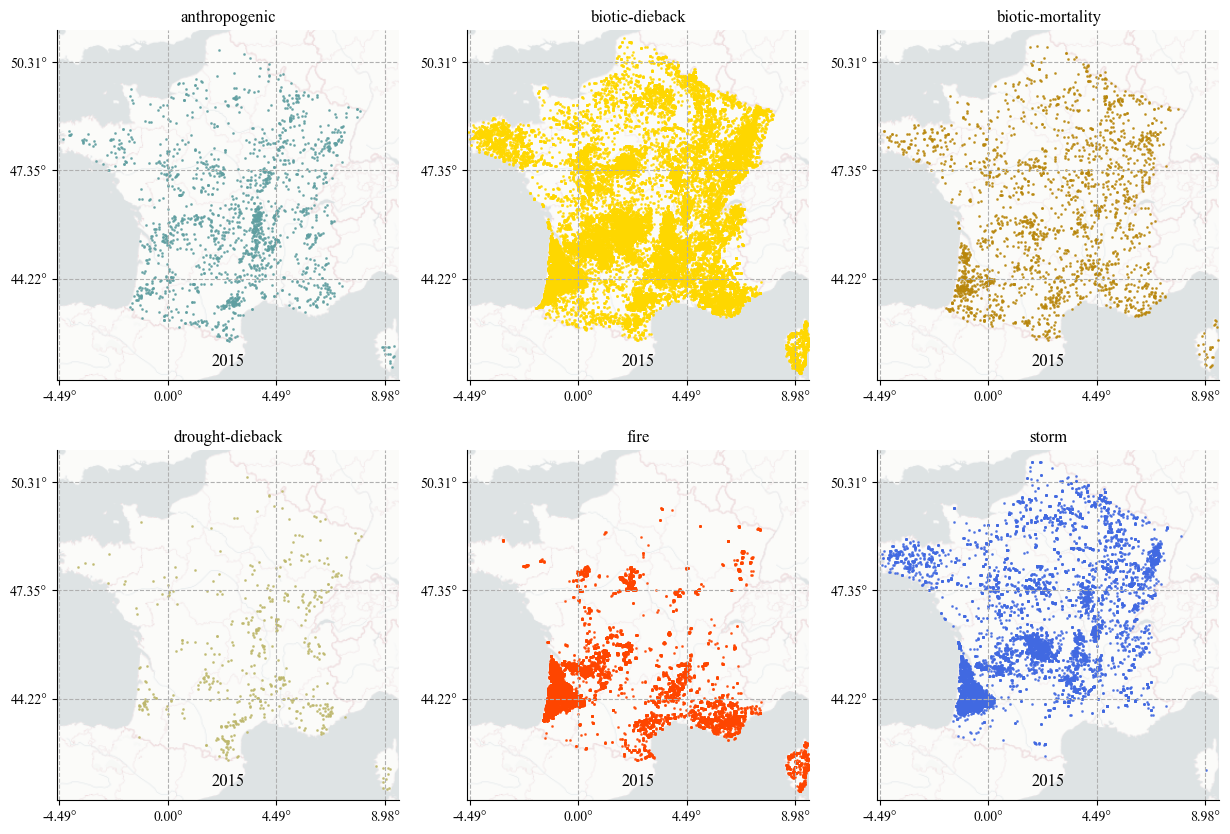

In [15]:
#animation 

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FuncFormatter
import contextily as cx
import math

plt.rcParams["font.family"] = "Times New Roman"


def update(year):
    # Clear previous axes
    for ax in axes:
        ax.clear()

    r = dict_results[year]
    #selection of the main disturbance 
    r = r[ r.index == 0]
    gdf_web_mercator = r.to_crs(epsg=epsg)

    for idx, class_name in enumerate(sorted(class_names)):
        row = idx // 3 
        col = idx % 3

        gdf = gdf_web_mercator[(gdf_web_mercator['Class'] == class_name)]
        ax = axes[idx]

        gdf.plot(ax=ax, color=custom_color_mapping[class_name], alpha=0.75, markersize=1)
        cx.add_basemap(ax, crs=gdf_web_mercator.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, alpha=0.75, zoom=5)
        
        ax.set_title(class_name)
        ax.axis('equal')
        ax.grid(True, linestyle='--')
        ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
        ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
        ax.annotate(year, xy=(0.5, 0), xytext=(0, 10), xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=12, color='black', fontname='Times New Roman')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim((minx, maxx))
        ax.set_ylim((miny, maxy))

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)
axes = [fig.add_subplot(gs[i // 3, i % 3]) for i in range(6)]

# Initialize the plot
update(2015)

# Create the animation
ani = FuncAnimation(fig, update, frames=range(2015, 2021), repeat=False)

# Save the animation
ani.save('../figures/forest_main_disturbances_animation_v0.1.gif', writer='ffmpeg', fps=1, dpi=300)
